In [ ]:
import cv2
from google.colab import drive
from PIL import Image
import io
import os
import tensorflow as tf
import datetime
from io import BytesIO
from skimage import feature
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

from tensorflow.keras.utils import to_categorical
import keras

#from keras.datasets import mnist, cifar10, cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Lambda, concatenate, add
from keras.models import Model
# from custom_layer import Exp_max
import tensorflow as tf
import numpy as np
from skimage.feature import greycomatrix
from tensorflow.keras.utils import plot_model

In [ ]:


def load_data(image_path):
  image_data = []
  image_label = []
  for (root, dirs, file) in os.walk(image_path):
      for f in file:
        l = root.split('/')
        image_label.append(l[-1])
        # image = f.read()
        image = Image.open(root+'/'+f)
        image = image.resize([128, 128], Image.ANTIALIAS)
        image = np.array(image)
        image_data.append(image)
        # print(l[-1],f)
  mapping = {}
  total_image_label = list(set(image_label))
  for x in range(len(total_image_label )):
    mapping[total_image_label[x]] = x

  # integer representation
  for x in range(len(image_label)):
    image_label[x] = mapping[image_label[x]]
  
  return np.array(image_data), np.array(image_label)

In [ ]:


drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_path = "drive/MyDrive/Datasets/KTH/train"
valid_path = "drive/MyDrive/Datasets/KTH/valid"

train_image,train_label = load_data(train_path)
valid_image,valid_label = load_data(valid_path)

In [ ]:
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		return lbp

In [ ]:
def convert_lbp(image_data):
  desc = LocalBinaryPatterns(24, 8)
  data = []
  for image in image_data:
    # load the image, convert it to grayscale, and describe it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mat = desc.describe(gray)
    # extract the label from the image path, then update the
    # label and data lists
    
    # data = numpy.resize(data,(32,32))
    dst = np.dstack([mat, mat, mat])
    data.append(dst)
  data = np.array(data)
  return data

In [ ]:
lbp_train_image = convert_lbp(train_image)

lbp_valid_image = convert_lbp(valid_image)
lbp_valid_image.shape

(1600, 128, 128, 3)

In [ ]:
def create_base_model(input_shape):
  
  
  image_input = Input(shape=input_shape)
  #image_grad_input = Lambda(find_grad_sum_input)(image_input)

  # 16 filter convolution
  cov_16 = Conv2D(16, (3, 3), activation='elu')
  
  x = cov_16(image_input)


  x = MaxPooling2D((2, 2))(x)
  
  # 32 filter convolution
  cov_32 = Conv2D(64, (3, 3), activation='elu')
  x = cov_32(x)
  
  x = MaxPooling2D((2, 2))(x)
  
 # 64 filter convolution
  cov_64 = Conv2D(128, (3, 3),activation='elu')
  x = cov_64(x)
  
  x = MaxPooling2D((2, 2))(x)
  

  
  final = Flatten()(x)#(final)
  
  # final = Dense(2024, activation='elu')(final)
  # final = BatchNormalization()(final)
  # final = Dropout(0.2)(final)

  

  final = Dense(512, activation='elu')(final)
  final = BatchNormalization()(final)
  final = Dropout(0.3)(final)

 

  final = Dense(512, activation='elu')(final)
  final = BatchNormalization()(final)
  final = Dropout(0.3)(final)

  out = Dense(11, activation='softmax')(final)
  model = Model(image_input, out)
  return model



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

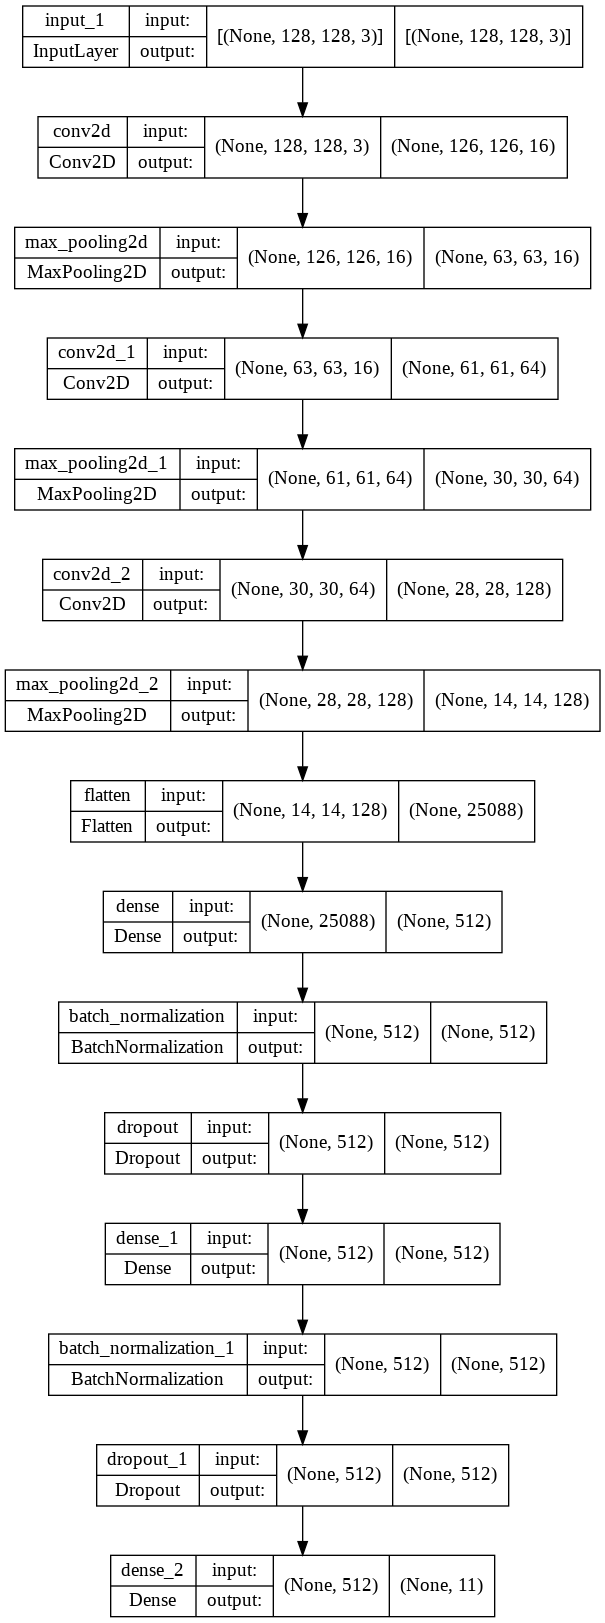

In [ ]:

input_shape = (128,128,3)
model = create_base_model(input_shape)
print(model.summary())

model.compile(
      # optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3, ),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, amsgrad=True,
 ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(lbp_train_image.astype('float32'),train_label, 
                    epochs = 100,
                    validation_data=(lbp_valid_image.astype('float32'), valid_label),
                    batch_size=128
)

Epoch 1/100
13/13 [==============================] - 15s 240ms/step - loss: 3.4687 - sparse_categorical_accuracy: 0.0922 - val_loss: 5.9105 - val_sparse_categorical_accuracy: 0.1269
Epoch 2/100
13/13 [==============================] - 2s 152ms/step - loss: 3.3576 - sparse_categorical_accuracy: 0.1053 - val_loss: 5.0586 - val_sparse_categorical_accuracy: 0.1088
Epoch 3/100
13/13 [==============================] - 2s 162ms/step - loss: 3.2576 - sparse_categorical_accuracy: 0.1147 - val_loss: 4.5371 - val_sparse_categorical_accuracy: 0.0900
Epoch 4/100
13/13 [==============================] - 2s 152ms/step - loss: 3.1384 - sparse_categorical_accuracy: 0.1248 - val_loss: 4.5193 - val_sparse_categorical_accuracy: 0.1550
Epoch 5/100
13/13 [==============================] - 2s 154ms/step - loss: 3.1328 - sparse_categorical_accuracy: 0.1279 - val_loss: 5.0096 - val_sparse_categorical_accuracy: 0.1619
Epoch 6/100
13/13 [==============================] - 2s 154ms/step - loss: 3.0601 - sparse_cat

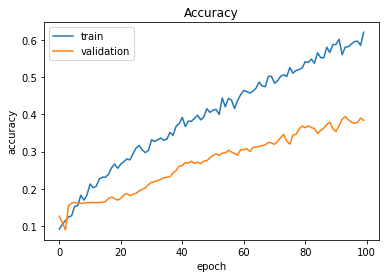

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()